# **Task 1.1 – Data preparation**

#### *In this section I have...*
--- 
<u>**Loaded the Glass Dataset**</u>
- loaded the dataset as a **dataframe** using pandas
- printed the first **5 columns** to check successful loading
- printed the **shape** of the dataset to further verify nothing went wrong
<br><br>

<u>**Checked for Dupicates and Missing Values**</u>
- printed the sum of **duplicates found**, and the rows identified 
- **dropped the duplicates**
- printed the **sum of missing values**, none were found - no further action taken
<br><br>

<u>**Normalised the Dataset**</u>
- **separated the targets** from the inputs - targets are numerical but we don't scale them, they would lose their meaning
- used **MinMaxScaler** to scale the dataset for all values to lie between 0-1
- plotted two columns before and after normalisation to ensure the **original shape was maintained**
  - this ensures the input values stayed *relative to their original values*, but now within a smaller range
<br><br>
---
#### <u>**Notes**:</u>
**Addressing duplicates** in a dataset this size duplicates are *unlikely* to impact the quality of the models significantly - BUT it is good practice so I decided to explore this regardless. 

**Normalisation**, scaling the input values between 0-1, is a crucial step as both kNN and SVM are **distanced based** models. Without scaling, features with large values can overpower the distance based calculations the models make to in order to classify.<br></br>
This leads to features being treated as *more <u>**OR**</u> less important* when classifying points - purely based on distance.<br></br>
Without scaling, the classifcations made in training *<u>**AND**</u>* the predictions made in testing are impacted - skewing results and influencing how the models behave and interpret the data.

---

In [1155]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

#### **Loading the Dataset**

In [1158]:
data = pd.read_csv("glass_dataset.csv") 
print(data.head(5), "\n") #print first 5 rows
print(data.shape) #check out the shape (columns) 

        RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1 

(214, 10)


#### **Checking for Duplicates and Missing Values**

In [1161]:
print("Duplicate count : ",data.duplicated().sum(), "\n") #print number of duplicates
print("Duplicate rows: \n", data[data.duplicated(keep=False)], "\n") #print present duplicate rows
data = data.drop_duplicates() #drop duplicates from our set
print("Duplicate count after drop : ",data.duplicated().sum(), "\n") #print number of duplicates again to verify drop

print("Missing count: ",data.isnull().sum().sum(), "\n") #calculate and print total sum of missing values

Duplicate count :  1 

Duplicate rows: 
          RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
38  1.52213  14.21  3.82  0.47  71.77  0.11  9.57  0.0  0.0     1
39  1.52213  14.21  3.82  0.47  71.77  0.11  9.57  0.0  0.0     1 

Duplicate count after drop :  0 

Missing count:  0 



#### **Normalising the Dataset**

In [1164]:
#separate the inputs (glass features) from the targets (glass types) 
inputs = data.drop(columns=["Type"]) 
targets = data["Type"]  

inputs_before = inputs.copy()

#normalise inputs
scaler = MinMaxScaler()
scaled = scaler.fit_transform(inputs)
data = pd.DataFrame(scaled, columns=inputs.columns)
data["Type"] = targets.reset_index(drop=True) #reattach the target to the scaled dataset 

#reassign inputs and targets after normalisation for later use
inputs = data.drop(columns=["Type"])
targets = data["Type"]

print("After scaling \n", data.max() - data.min()) #print the range after scaling 

After scaling 
 RI      1.0
Na      1.0
Mg      1.0
Al      1.0
Si      1.0
K       1.0
Ca      1.0
Ba      1.0
Fe      1.0
Type    6.0
dtype: float64


#### **Verifying Normalisation Correctness**

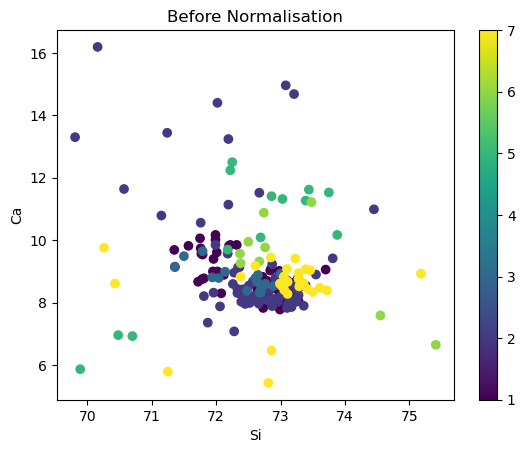

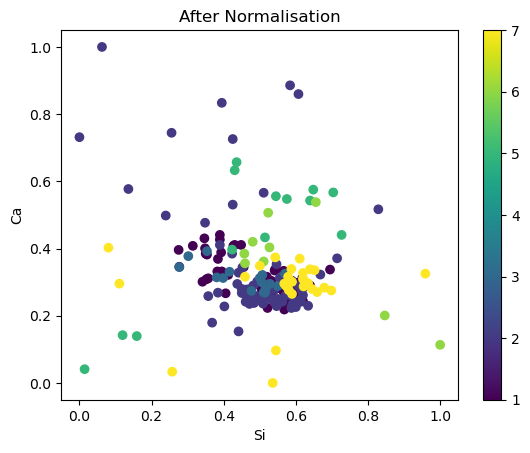

In [1167]:
#function to plot two columns(inputs) before and after scaling
def plot_scale_effects(dataset, input_1, input_2, targets, title):
    plt.scatter(dataset[input_1], dataset[input_2], c=targets, cmap="viridis")
    plt.colorbar()
    plt.title(title)
    plt.xlabel(input_1)
    plt.ylabel(input_2)
    plt.show()

plot_features(inputs_before, "Si", "Ca", targets, "Before Normalisation")
plot_features(data, "Si", "Ca", targets, "After Normalisation")


# **Task 1.2 – Classification**

#### <u>*In this section I have...*</u>
--- 
<u>**Split the normalised dataset into 4 parts using a random seed for reproducibility**</u>
- X_train to train the model on inputs (glass features)
- X_test to test the model on **unseen** inputs (glass features)
- y_train to train the model on targets (types of glass)
- y_test to test the model on targets (types of glass)
  <br><br>

<u>**Tested the Train and Test Accuracy Scores of 2 models with various parameters**</u>
- used a loop to train a **kNN** Classifier with neighbours ranging **1-20**
- used a loop to train an **SVM** Classifier with kernel shapes: **linear, polynomial, radial**
- plotted the performance of each model + parameter combination using their **test and train scores**
  <br><br>

<u>**Predicted Points using the Best Models Found**</u>
- predicted points using the best found kNN 
- predicted points using the best found SVM 
  - plotted the prediction results for both using a **confusion matrix**
  <br><br>
---
#### <u>**Notes**:</u>
Although full analysis is to come in Task 1.3, **for each model with X parameters** I have analysed and discussed **possible reasons behind their scores** - as a high accuruacy score doesn't necessarily equate to a good and stable model.

---

In [1170]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

#### **Splitting the Dataset into Testing and Training Sets**

In [1173]:
#split with random seed for reproducability 
#stratify targets so the balance of classes is relative to that of the original set 
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, stratify=targets, random_state=42) 

#### **Defining Parameters, Score Storage, and Function to Plot Accuracy**

In [1176]:
#define k=n values and score archives
k_values = range(1, 21) 
k_train_score = [] 
k_test_score = []

#define kernel shapes and score archives
kernel_shape =['linear', 'poly', 'rbf']
kernels = ['Linear', 'Poly2', 'Poly3', 'Rbf']
s_train_score = []
s_test_score = []

#reusable function to plot the train and test accuracy scores of a model
def plot_accuracy(title,label,ticks,values,train,test):
    plt.figure()
    plt.xlabel(label)
    plt.xticks(ticks)
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.scatter(values, train, color='green', label="Training Accuracy")
    plt.scatter(values, test, color='red', label="Test Accuracy", marker="x")
    plt.legend()
    plt.show()

#### **Training and Testing KNN, Plotting Train and Test Accuracy Scores**

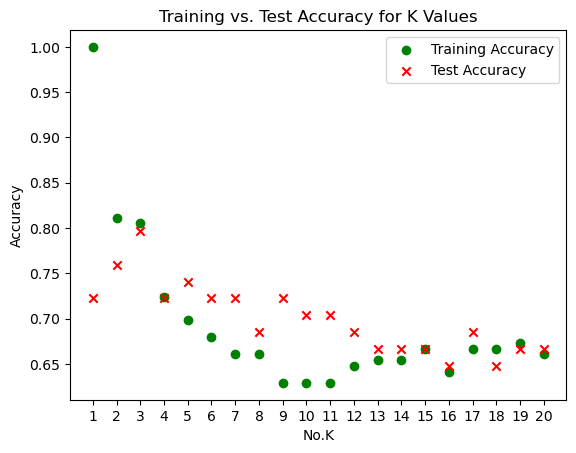

In [1179]:
#loop through all k=n values (1-20)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train) #fit the model with the training data
    
    #test the model on the training set and testing set and retrieve accuracy score of both
    k_train_score.append(knn.score(X_train, y_train)) 
    k_test_score.append(knn.score(X_test, y_test)) 

#plot scores for each k=n value
plot_accuracy("Training vs. Test Accuracy for K Values","No.K", k_values,k_values, k_train_score, k_test_score)

#### **Best kNN Discussion**
</br>

**A Misleading K=1**

---
The highest *training* accuracy was achieved at **k=1 with a 1.00 score**, however this perfect score is more than likely due to there only being one neighbour meaning **each data point predicts itself** as it is the nearest and only existing neighbour. We can see this reflected in the **test score**, which significantly dropped since the model can no longer use itself as the nearest neighbour, and instead relies on new unseen points.<br></br>

**K=3, The Optimal Choice**

---
The **best performance overall was achieved at k=3**. It achieved a training accuracy of 0.80 and a test accuracy only slightly lower at 0.79. With k=3, the model seems to be reacting well to unseen data since the test score is only slightly lower than the training score. Due to it yielding the best test score I will **carry this model forward** to Task 1.3.<br></br>

**K=3 Onwards**

---

Beyond k=3 we start to see the accuracy scores for *both* training and test data lower quite significantly, this is likely due to **underfitting**. Since the KNN model relies on nearest neighbours to make predictions, the more neighbours it has the broader the group of data points the model attempts to consider resulting in an overly "cautious" model - a concept we can simplify by saying the model considers a wide range of variables and selects the "safest" choice, or the average. We can see this happening as it is **performing poorly on both sets** of data as the k value increases. <br></br>

#### **Training and Testing SVM, Plotting Train and Test Accuracy Scores**

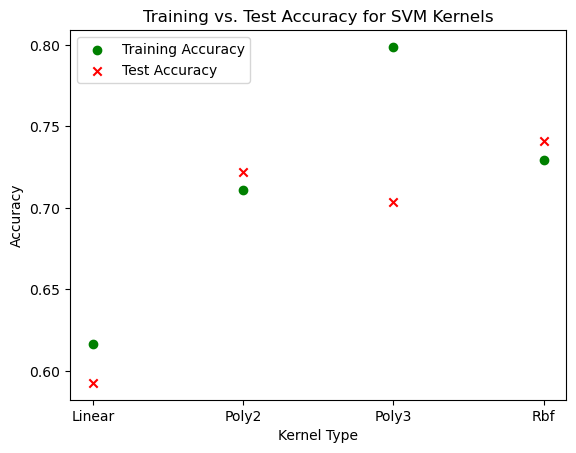

In [1183]:
#loop through desired kernel shapes (linear, poly, radial)
for s in kernel_shape:
    if s == 'poly': #for polynomial kernel limit search to degree 2,3
         for degree in [2,3]:
             svm = SVC(kernel=s, degree=degree)
             svm.fit(X_train, y_train) 
             
             #test the model on the training set and testing set and retrieve accuracy score of both
             s_train_score.append(svm.score(X_train, y_train))
             s_test_score.append(svm.score(X_test, y_test))
             
    else:
        svm = SVC(kernel=s)
        svm.fit(X_train, y_train)
        
        s_train_score.append(svm.score(X_train, y_train))
        s_test_score.append(svm.score(X_test, y_test))

#plot scores for each kernel 
plot_accuracy("Training vs. Test Accuracy for SVM Kernels", "Kernel Type", range(len(kernels)),kernels, s_train_score, s_test_score)


#### **Best SVM Discussion**
</br>

**Linear Shape**

---
We can see both the test and training results for the linear shape are quite poor. This is likely because the dataset is focussed on classifying types of glass, which inherently share similar features. The linear kernel shape draws a **straight decision boundary** which is suitable when features are linearly seperable. Unfortunately in our case the feature space is quite confused and contains **class overlap** making linear seperation ineffective. 
<br></br>

**Polynomial [Degree 2]**

---
The degree 2 polynomial kernel performed much better than linear, likely because it draws a **curved decision boundary** which would offer far more flexibility when seperating overlapping classes. 
<br></br>


**Polynomial [Degree 3]**

---
Changing to degree 3, the polynomial shape appears to be behaving really well based on it's training score, however we see the test score drop significantly - a clear sign the model is **overfitting** and not adapting to new unseen data. This can happen because the shape is now **too flexible** and can fit itself to or pick up on patterns that aren't actually relevant causing the model to get to know patterns relative only to the training set and perform really well, but much worse on test sets where it can't apply those learned patterns to predict points. This means this state of the model is not only inaccurate but it **cannot generalise** properly. 
<br></br>


**Radial Shape**

---

Radial shape has given us the **best score overall**. Here we see our best test score, and the training score is not too far off so it is likely the model is not underfitting or overfitting. Radial being the strongest shape here is due to it's ability to draw completely **non linear decision boundaries**, which is perfect for our glass dataset. Since the dataset has confused feature space with overlapping classes, radial is the most suitable as it can place it's boundaries based on the structure of the data and clusters of points instead of relying on fixed lines or curves like the previous shapes would. 
<br></br>


#### **Predicting Points With Models**

In [1187]:
from sklearn.utils.multiclass import unique_labels

#### **Define a Function to Plot Confusion Matrices**

In [1190]:
#reusable function to plot the predicted vs true classifications of a model
def confusion(types, predictions, labels, title): 
    matrix = confusion_matrix(y_test, classifications)
    plt.figure()
    plt.imshow(matrix)
    plt.colorbar()
    plt.xlabel("Predicted Type")
    plt.ylabel("Actual Type")
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.yticks(ticks=range(len(labels)), labels=labels)
    plt.title(title)
    plt.show()

#### **Predict Points with kNN**

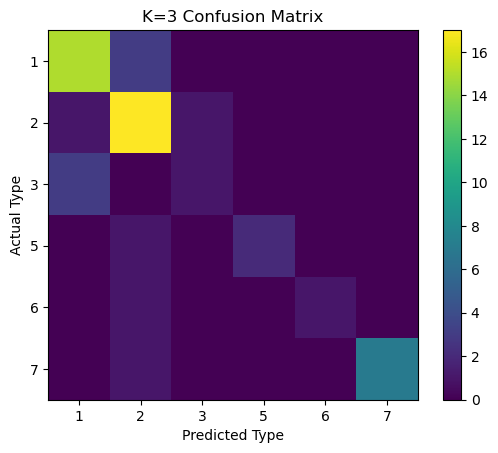

In [1193]:
knn = KNeighborsClassifier(n_neighbors=3) 
#fit the model and predict points in unseen data
knn.fit(X_train, y_train)
classifications = knn.predict(X_test)

matrix_labels = unique_labels(y_test, classifications)
matrix_ticks = range(len(matrix_labels))
confusion(y_test, classifications, labels=matrix_labels, title= "K=3 Confusion Matrix")

#### **KNN Prediction Discussion**
<br>

**Inaccuracies**

---
The confusion matrix for our KNN (k=3), shows that **not all predictions lie on the diagonal** - we can immediately see that the model is often misclassifying points and is therefore inaccurate. 

**Observations**

---
An interesting observation here is that the model is currently **predicting glass type 2 the most**, even when it's wrong. Additionally, the model seems to be **classifying glass type 7 the most accurately**. These are both things that will be explored further in Task 1.3.<br></br>

#### **Predict Points with SVM**

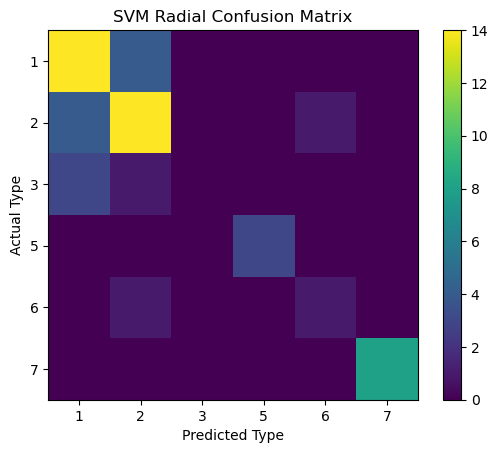

In [1197]:
svm = SVC (kernel = 'rbf')  
#fit the model and predict points in unseen data
svm.fit(X_train, y_train)
classifications = svm.predict (X_test)

matrix_labels = unique_labels(y_test, classifications)
matrix_ticks = range(len(matrix_labels))
confusion(y_test, classifications, labels=matrix_labels, title= "SVM Radial Confusion Matrix")

#### **SVM Prediction Discussion**
<br>

**Inaccuracies**

---
The confusion matrix for our SVM with a radial shape again shows **not all predictions lie on the diagonal** - this model is also misclassifying points and is inaccurate. 

Here we see similar patterns to the previous KNN matrix, with **type 2 being the most often predicted** even when it's wrong, although not quite as often as KNN did.

**Observations**

---
**One interesting observation** is that our SVM model displays but our KNN doesn't is that it **has not predicted type 3** a single time, despite it being present in the dataset given to both models. To me, this suggests type 3 points were too far from the decision boundary to be considered important when classifying - something I will **explore further in Task 1.3**. <br></br>

# **Task 1.3 – Assessment of Classification**

#### <u>*In this section I have...*</u>
--- 

In [1201]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

#### **Performing Cross Validation on the Best KNN and SVM Models**

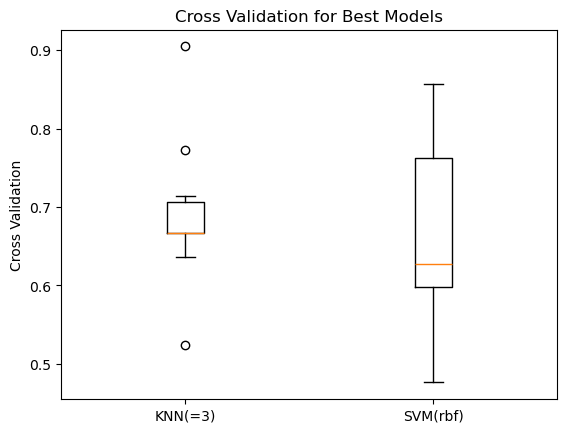

In [1204]:
k_folds = KFold(n_splits=10, shuffle=True, random_state=42)

#cross validate knn with our best_k_value (3)
knn = KNeighborsClassifier(n_neighbors=3) 
knn_scores = cross_val_score(knn, inputs, targets, cv=k_folds)

#cross validate svm with our best shape (radial)
svm = SVC(kernel='rbf') 
svm_scores = cross_val_score(svm, inputs, targets, cv=k_folds)

#box plot for knn and svm accuracy scores 
plt.figure()
plt.title("Cross Validation for Best Models") 
plt.boxplot([ knn_scores,svm_scores])
plt.xticks( [1 , 2 ] , ["KNN(=3)" , "SVM(rbf)"])
plt.ylabel("Cross Validation") 
plt.show()

#### **Summary of Results**
<br>

**Boxplot Overview**

---

The box plot of our cross validation results show that **KNN had a higher median accuracy** (shown by the orange line) and a lower variance in accuracy (shown by the tigher box). KNN seems to have **performed consistently** across different folds, but it did have **3 outliers**. 

Constrastingly, **SVM had a lower median accuracy** and although it had no outliers, the variance in accuracy is much higher which suggests that SVMs **performance fluctuated** significantly through different folds.<br><br>


**What Does This Tell Us?**

---
Both **kNN and SVM are distance based** machine learning algorithms, this means the classifications they make are largely dependent on the distance between data points. They have a subtle but important difference though, **kNN is a  lazy learner** and **SVM is an eager learner** - this means the way they determine what points are "important" enough to base a classification on is quite different. <br><br>

As a lazy learner, kNN makes predictions **based on the majority label** of it's nearest neighbours. This means KNN's performance will vary somewhat randomly when the data surrounding the test point changes, as it's predictions are based purely on whatever label appears most on the surrounding points (nearest neighbours). <br><br>

This could explain our 3 outliers, since kNN esssentially relies on the majority vote of it's neighbours and does not truly learn or recognise patterns - the model is more **"randomly lucky or unlucky"** in it's predictions resulting in massive drops and increases in accuracy. 

As an eager learner **SVM sets "rules"** that it uses for classifying points, known as **decision boundarys**. A decision boundary is essentially a region that the SVM has decided equates to a target (X). In simple terms, the SVM **outlines a cluster** of data points in the feature space and goes "anything that lands in my region X must therefore be also be X". 

This "rule set" is decided for each fold. This means the SVM **redraws decision boundaries** based on the data it is given. Since the given data fluctuates accross folds, the SVM could deem certain data points more or less "important" - placing them closer or further away from the boundary than perhaps it did previously. This leads to different prediction outcomes and accuracy scores every time. 

As the SVMs predicitons are influenced by the data points closest to the boundary/region of a target (X), instead of all neighbouring data points like kNN, SVMs predicitons and accuracy will vary significantly more than kNN's would.

---


#### **The Bigger Picture: Prediction Influence**

Although both models seemingly performed *OK* with accuracy scores generally ranging between 0.65 and 0.75 there are deeper factors to be considered before deciding if either model is stable, or even trustworthy. 

---
**Multi-Class Classification of Ambiguous Targets**

The task we have presented our models with is a multi-class classification problem, where 9 inputs are to be used in classifying a data point as one of 6 types of glass.

*Why is this problematic for our models?* Well, both models are fundamentally flawed in classifying points in problems where feature overlap is prevelant. 
Feature overlap occurs when different targets share very similar characteristics across the inputs. This makes it difficult to distinguish between classes in the feature space, as data points from different types may appear almost identical and therefore overlap. 

Feature overlap causes kNN to struggle when predicting targets, as it's nearest neighbours may be incorrectly grouped. Since kNN essentially relies on the label of it's nearest neighbours (the data points surrounding the target (?)) when predicting a point, if the majority of the surrounding points are labelled (X) kNN will predict target (X). This is a problem as when feature overlap is present, a data point that truly belongs to target Y may be tangled up in a cluster of target X, meaning it's nearest neighbours will convince it that target Y must *actually* be target X - even though it's not.

SVM is impacted slightly differently. Since it draws decision boundaries, or "regions", to base it's predicitons on - when classes overlap in the feature space it will struggle to draw a boundary accurately. Essentially the SVM likes to draw boundaries around clusters of points and say "this is my target (X) region, anything that also lands here must also be (X)" While this strategy can work when features are linearly seperable, when features are overlapping the clusters of points are confused and tangled - containing many different classes. This can lead to the SVM attempting to draw a boundary for target (X) while also accidentally caputuring targets Y and Z in the same boundary. This leads to the SVM predicting those classes, especially Y and Z, inaccurately quite often.

If we dig a little deeper, we can actually visualise the problems discussed and see for *ourselves* if our suspicions are indeed true... 

#### **2D Visualisation of The Feature Space**

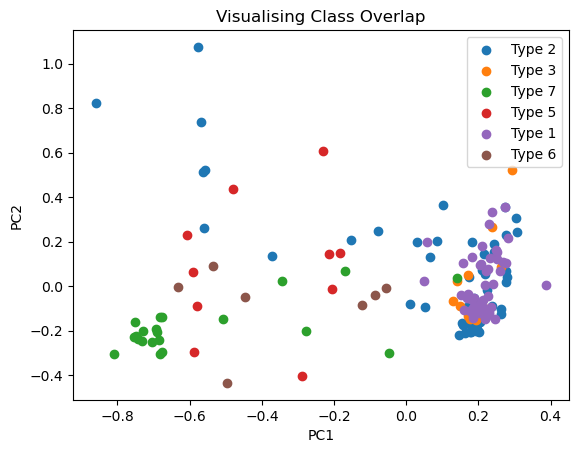

In [1209]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

complete_set = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
complete_set["Type"] = y_train.values

glass_types = y_train.unique()

for g in glass_types:
    group = complete_set[complete_set["Type"] == g]
    plt.scatter(group["PC1"],group["PC2"],label=f"Type {g}",)
    
plt.title("Visualising Class Overlap")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In the scatter graph above we can visually see how points, belonging to different targets of glass, overlap.
On the right side, we can see a big cluster of the classes: Type 1, 2, 3, and 7. This is a significant overlap, depsite belonging to different classes, these data points are so similar they cannot be properly distinguished and therefore form this confused and tangled looking cluster that will confuse our models.

We also have a spread of classes where points are "floating" and don't really exist within a cluster, this suggests there could be some meaningless data, or "noise", where uneeded or incorrect data is present in the dataset. There is a chance that some of these points aren't actually noise and are genuine outliers, but to know if this true we would need to understand how glass types are formed in the real world in order to properly filter out noise from genuine high value points.

The most accurate cluster is on the left side in green, this is type 7. Since in this cluster there are no overlapping features, we can reasonably assume this would be the most accurately predicted class by our models. 

With this insight, lets see how our models behave when presented with this dataset...

#### **Defining a Function to Plot Boundaries**

In [1213]:
from sklearn.inspection import DecisionBoundaryDisplay

def plot_boundary(model, X, y, title="Decision Boundary", edgecolor="black"):
    display = DecisionBoundaryDisplay.from_estimator(model, X, response_method="predict")
    
    points = display.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolor=edgecolor)
    handles, labels = points.legend_elements()
    
    display.ax_.legend(handles, labels, title="Class")
    display.ax_.set_title(title)
    plt.show()

#### **Visualising SVM Decisions**

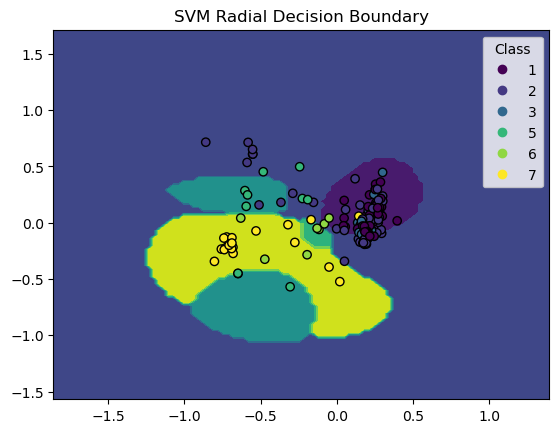

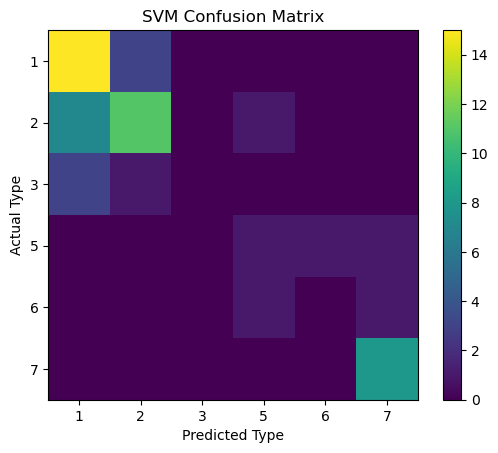

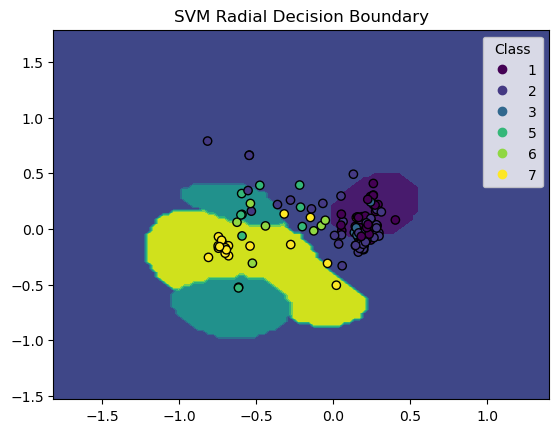

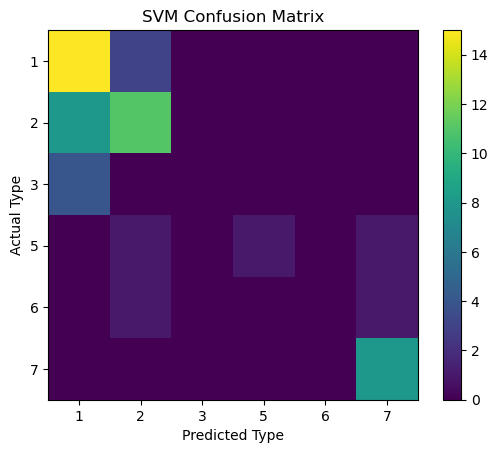

In [1216]:
for r in [1,2]:
    X_train, X_test, y_train, y_test = train_test_split(inputs, targets, stratify=targets, random_state=r)
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    exp_svm = SVC(kernel = 'rbf') 
    exp_svm.fit(X_train_pca, y_train)
    classifications = exp_svm.predict (X_test_pca)

    plot_boundary(exp_svm, X_train_pca, y_train, title="SVM Radial Decision Boundary")
    confusion(y_test, classifications, labels=matrix_labels, title= "SVM Confusion Matrix")
    

#### **What Can We See?**

#### **Visualising KNN Decisions**

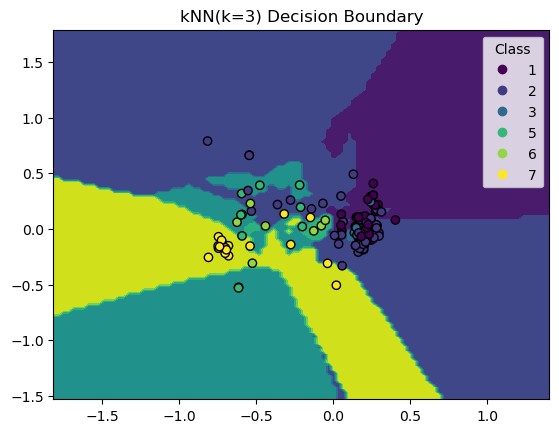

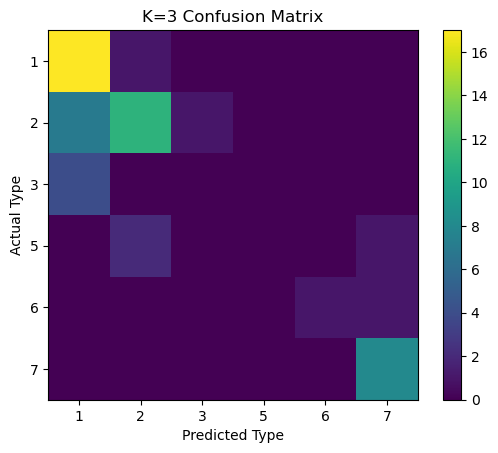

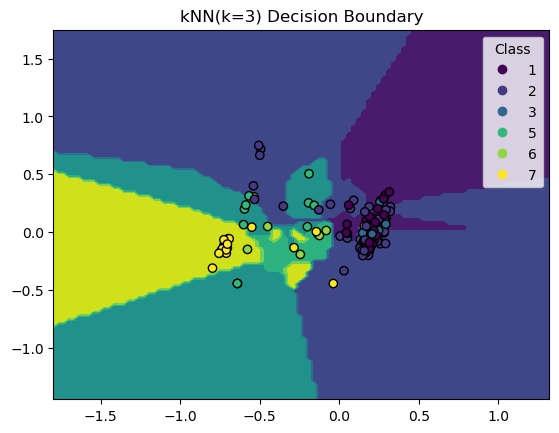

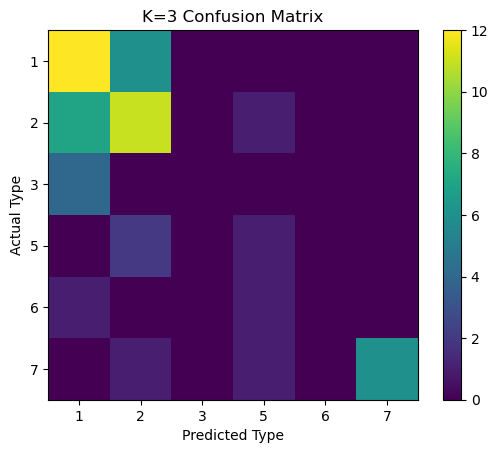

In [1220]:
for r in [2,3]:
    X_train, X_test, y_train, y_test = train_test_split(inputs, targets, stratify=targets, random_state=r)
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    exp_knn = KNeighborsClassifier(n_neighbors=3) 
    exp_knn.fit(X_train_pca, y_train)
    classifications = exp_knn.predict (X_test_pca)
    plot_boundary(exp_knn, X_train_pca, y_train, title="kNN(k=3) Decision Boundary")
    confusion(y_test, classifications, labels=matrix_labels, title= "K=3 Confusion Matrix")

#### **What Can We See?**

You also might notice that both models, but especially kNN, are predicting type 2 and 1 the most frequently even when it was wrong. 

This is an indication that the models are suffering from class imbalance, where over represented models dominate the dataset and feature space causing models to favour the majority class.

In the case of kNN, this can cause it to predict the majority class simply because there are *so* many of those points that statiscally speaking there is a very high chance that it's nearest neighbours will be labelled that class leading to deduce that it's point surely must be that class. This also dampens the higher accuracy scores that we saw earlier because while there is a high chance that the nearest neighbours are the majority class the chance that the point it's predicting is ALSO that class. 

SVM also suffers from class imbalance, but in a different way since the underrepresented classes will have scarce support vectors due to a lack of available points in the dataset. This could result in very few points from that class lying close to the decision boundary, meaning predictions for that class are made less often, if at all. 

We can see from the feature overlap graph that there is some imbalance, but to solidify that we can also plot a bar graph to understand just how imbalanced the set is a bit clearer. 

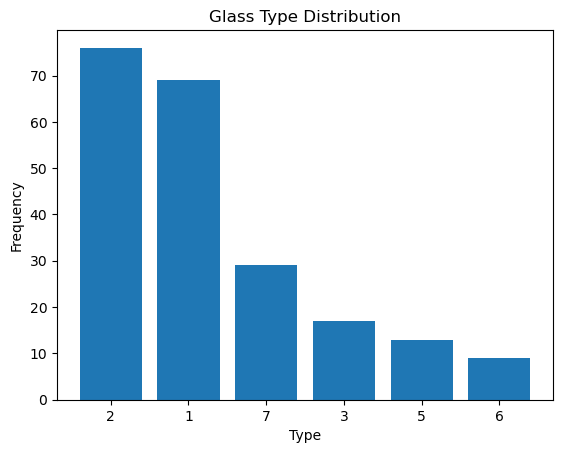

In [1224]:
target_counts = targets.value_counts()

plt.bar(target_counts.index.astype(str), target_counts.values)
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.title('Glass Type Distribution')
plt.show()

As you can see type 2 and 1 are massively overrrepresented in comparison to the rest of the types in the dataset. This helps to confirm the suspicions and nuances that we saw in the way the models were making predictions